In [4]:
import matplotlib.pyplot as plt
import numpy as np
import tenseal as ts
import torch
import torch.nn as nn


In [5]:

def random_data(m=1024, n=1):
    # data separable by the line `y = x`
    x_train = torch.rand(m, n)
    x_test = torch.rand(m // 2, n)
    y_train = (x_train[:, 0] > 0.5).float().unsqueeze(0).t()
    y_test = (x_test[:, 0] > 0.5).float().unsqueeze(0).t()
    return x_train, y_train, x_test, y_test


In [6]:
x_train, y_train, x_test, y_test = random_data(m=10000)


class SampleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(1, 16)
        self.layer2 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer1(x)
        x = self.sigmoid(x)
        x = self.layer2(x)
        x = self.sigmoid(x)
        return x


sample_model = SampleModel()
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(sample_model.parameters())
batch_size = 10
data = torch.split(x_train, batch_size)
y = torch.split(y_train, batch_size)

for epoch in range(5):
    for i in range(len(data)):
        optimizer.zero_grad()
        output = sample_model(data[i])
        loss = loss_fn(output, y[i])
        loss.backward()
        optimizer.step()
        accuracy = (output.round() == y[i]).float().mean()
        print('Epoch {} Loss {} Accuracy {}'.format(epoch, loss.item(), accuracy))

with torch.no_grad():
    output_test = sample_model(x_test)
    accuracy_test = (output_test.round() == y_test).float().mean()
    print('Test Accuracy:', accuracy_test.item())

Epoch 0 Loss 0.7822977304458618 Accuracy 0.5
Epoch 0 Loss 0.9574588537216187 Accuracy 0.30000001192092896
Epoch 0 Loss 0.867816150188446 Accuracy 0.4000000059604645
Epoch 0 Loss 0.7790927886962891 Accuracy 0.5
Epoch 0 Loss 0.775871753692627 Accuracy 0.5
Epoch 0 Loss 0.7747112512588501 Accuracy 0.5
Epoch 0 Loss 0.9447275996208191 Accuracy 0.30000001192092896
Epoch 0 Loss 0.5234423875808716 Accuracy 0.800000011920929
Epoch 0 Loss 0.7732211351394653 Accuracy 0.5
Epoch 0 Loss 0.6874710321426392 Accuracy 0.6000000238418579
Epoch 0 Loss 0.5252361297607422 Accuracy 0.800000011920929
Epoch 0 Loss 1.0057170391082764 Accuracy 0.20000000298023224
Epoch 0 Loss 0.7639235258102417 Accuracy 0.5
Epoch 0 Loss 0.6835639476776123 Accuracy 0.6000000238418579
Epoch 0 Loss 0.8408170938491821 Accuracy 0.4000000059604645
Epoch 0 Loss 0.6078585982322693 Accuracy 0.699999988079071
Epoch 0 Loss 0.529931902885437 Accuracy 0.800000011920929
Epoch 0 Loss 0.6819403171539307 Accuracy 0.6000000238418579
Epoch 0 Loss 0

In [7]:

def test_layer_by_layer_model(sample_model, data):
    layer1_weight = sample_model.layer1.weight.data.T
    layer1_bias = sample_model.layer1.bias.data
    layer2_weight = sample_model.layer2.weight.data.T
    layer2_bias = sample_model.layer2.bias.data
    for data_point in data:
        layer_1 = nn.Sigmoid()(data_point.mm(layer1_weight) + layer1_bias)
        layer_2 = nn.Sigmoid()(layer_1.mm(layer2_weight) + layer2_bias)
        assert layer_2 == sample_model(data_point)
    print("vsyo ok")

In [8]:
data = torch.split(x_test, 1)

test_layer_by_layer_model(sample_model, data)

vsyo ok



# Encrypting data


In [9]:
# Create the TenSEAL security context
def create_ctx():
    """Helper for creating the CKKS context.
    CKKS params:
        - Polynomial degree: 8192.
        - Coefficient modulus size: [40, 21, 21, 21, 21, 21, 21, 40].
        - Scale: 2 ** 21.
        - The setup requires the Galois keys for evaluating the convolutions.
    """
    bits_scale = 26

    poly_mod_degree = 16384

    coeff_mod_bit_sizes = [31, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale,
                           bits_scale, 31]
    ctx = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
    ctx.global_scale = pow(2, bits_scale)
    ctx.generate_galois_keys()

    # We prepare the context for the server, by making it public(we drop the secret key)
    server_context = ctx.copy()
    server_context.make_context_public()

    return ctx, server_context



In [10]:
# Helper for encoding the image
def prepare_input(ctx, plain_input):
    enc_input = ts.ckks_vector(ctx, plain_input)
    return enc_input


def prepare_input_encrypted(context: bytes, ckks_vector: bytes) -> ts.CKKSVector:
    try:
        ctx = ts.context_from(context)
        enc_x = ts.ckks_vector_from(ctx, ckks_vector)
    except:
        raise DeserializationError("cannot deserialize context or ckks_vector")
    try:
        _ = ctx.galois_keys()
    except:
        raise InvalidContext("the context doesn't hold galois keys")
    return enc_x



In [11]:
context, server_context = create_ctx()


(array([2.936e+03, 1.222e+03, 5.000e+02, 2.110e+02, 8.500e+01, 2.300e+01,
        1.400e+01, 2.000e+00, 4.000e+00, 3.000e+00]),
 array([1.39284528e-09, 2.55802156e-05, 5.11590383e-05, 7.67378610e-05,
        1.02316684e-04, 1.27895506e-04, 1.53474329e-04, 1.79053152e-04,
        2.04631975e-04, 2.30210797e-04, 2.55789620e-04]),
 <BarContainer object of 10 artists>)

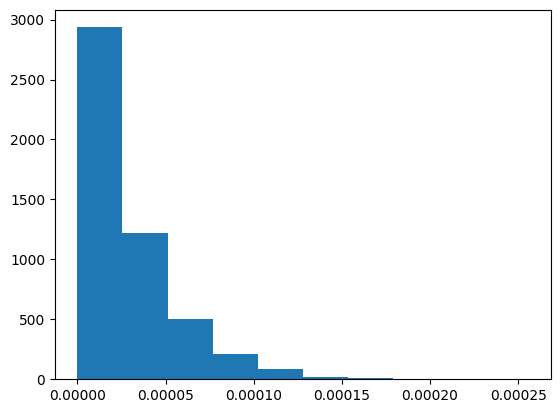

In [12]:
plt.hist(
    np.abs(np.array(prepare_input(context, torch.flatten(x_test)).decrypt()) - np.array(torch.flatten(x_test))))




# encrypted model

In [13]:
layer1_weight = sample_model.layer1.weight.data.T
layer1_bias = sample_model.layer1.bias.data
layer2_weight = sample_model.layer2.weight.data.T
layer2_bias = sample_model.layer2.bias.data
        # layer_1 = nn.Sigmoid()(data_point.mm(layer1_weight) + layer1_bias)
        # layer_2 = nn.Sigmoid()(layer_1.mm(layer2_weight) + layer2_bias)
x_train, y_train, x_test, y_test = random_data(m=1000)

# Decryption of result
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
errors = []
mean_err = []
for data, target in zip(x_train, y_train):
    # Encoding and encryption
    x_enc = prepare_input(context, data)
    enc_x = x_enc.mm(layer1_weight) + layer1_bias
    enc_x = nn.Sigmoid()(torch.tensor(enc_x.decrypt()))
    enc_x = prepare_input(context, enc_x)
    # enc_x = -0.004*enc_x*enc_x*enc_x+ 0.197*enc_x + 0.5
    enc_output = enc_x.mm(layer2_weight) + layer2_bias
    # enc_output = -0.004*enc_x*enc_x*enc_x+ 0.197*enc_x + 0.5
    # Decryption of result
    output = enc_output.decrypt()
    output = nn.Sigmoid()(torch.tensor(output))

    output = torch.tensor(output).view(1, -1)
    not_enc_model_output = sample_model(torch.tensor(data).type(torch.float))
    mean_err.append(torch.abs(not_enc_model_output - output))
    # compute loss
    if (not_enc_model_output > 0.5) == (output > 0.5):
        errors.append(1)
    else:
        errors.append(0)
print(f"Accuracy for binary prediction : {sum(errors) / len(errors)}")
mean_err = sum(mean_err) / len(x_train)
print(f"Mean Error per value for prediction {mean_err}")

/tmp/ipykernel_189358/1168088756.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = torch.tensor(output).view(1, -1)
/tmp/ipykernel_189358/1168088756.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  not_enc_model_output = sample_model(torch.tensor(data).type(torch.float))


Accuracy for binary prediction : 0.999
Mean Error per value for prediction tensor([[0.0005]], grad_fn=<DivBackward0>)


# Trainable encrypted model

In [30]:
layer1_weight = sample_model.layer1.weight.data.T
layer1_bias = sample_model.layer1.bias.data
layer2_weight = sample_model.layer2.weight.data.T
layer2_bias = sample_model.layer2.bias.data


class EncryptedLR:

    def __init__(self, sample_model):
        self.layer1_weight = sample_model.layer1.weight.data.T
        self.layer1_bias = sample_model.layer1.bias.data
        self.layer2_weight = sample_model.layer2.weight.data.T
        self.layer2_bias = sample_model.layer2.bias.data

        self._delta_w = 0
        self._delta_b = 0
        self._count = 0

    def forward(self, enc_x):
        enc_x = enc_x.mul(self.layer1_weight) + self.layer1_bias
        enc_out = EncryptedLR.sigmoid(enc_x)
        enc_out = enc_out.mm(self.layer2_weight) + self.layer2_bias
        enc_out = EncryptedLR.sigmoid(enc_out)
        enc_out = enc_out.reshape([1])
        return enc_out

    def backward(self, enc_x, enc_out, enc_y): # only needed if error is too much
        out_minus_y = (enc_out - enc_y)
        self._delta_w += enc_x * out_minus_y
        self._delta_b += out_minus_y
        self._count += 1

    def update_parameters(self):
        if self._count == 0:
            raise RuntimeError("You should at least run one forward iteration")
        # update weights
        # We use a small regularization term to keep the output
        # of the linear layer in the range of the sigmoid approximation
        self.layer2_weight -= self._delta_w * (1 / self._count) + self.layer2_weight * 0.05
        self.layer2_bias -= self._delta_b * (1 / self._count)
        # reset gradient accumulators and iterations count
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0

    @staticmethod
    def sigmoid(enc_x):
        # We use the polynomial approximation of degree 3
        # sigmoid(x) = 0.5 + 0.197 * x - 0.004 * x^3
        # from https://eprint.iacr.org/2018/462.pdf
        # which fits the function pretty well in the range [-5,5]
        return enc_x.polyval([0.5, 0.197, 0, -0.004])

    def plain_accuracy(self, x_test, y_test):
        # evaluate accuracy of the model on
        # the plain (x_test, y_test) dataset
        w = torch.tensor(self.layer1_weight)
        b = torch.tensor(self.layer1_bias)
        w_2 = torch.tensor(self.layer2_weight)
        b_2 = torch.tensor(self.layer2_bias)
        out = torch.sigmoid(x_test.matmul(w) + b)
        out = torch.sigmoid(out.matmul(w_2)+b_2)
        correct = (y_test>0.5) == (out>0.5)
        return correct.float().mean()

    def encrypt(self, context):
        self.layer1_weight = ts.ckks_tensor(context, self.layer1_weight)
        self.layer1_bias = ts.ckks_tensor(context, self.layer1_bias)
        self.layer2_weight = ts.ckks_tensor(context, self.layer2_weight)
        self.layer2_bias = ts.ckks_tensor(context, self.layer2_bias)

    def decrypt(self):
        print(self.layer1_weight)
        print('333333333333333')
        self.layer1_weight = self.layer1_weight.decrypt().tolist()
        self.layer1_bias = self.layer1_bias.decrypt().tolist()
        self.layer2_weight = self.layer2_weight.decrypt().tolist()
        self.layer2_bias = self.layer2_bias.decrypt().tolist()

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

############# Data summary #############
x_train has shape: torch.Size([100, 1])
y_train has shape: torch.Size([100, 1])
x_test has shape: torch.Size([50, 1])
y_test has shape: torch.Size([50, 1])
#######################################
Encryption of the training_set took 4 seconds
Distribution on plain data - Layer 1:


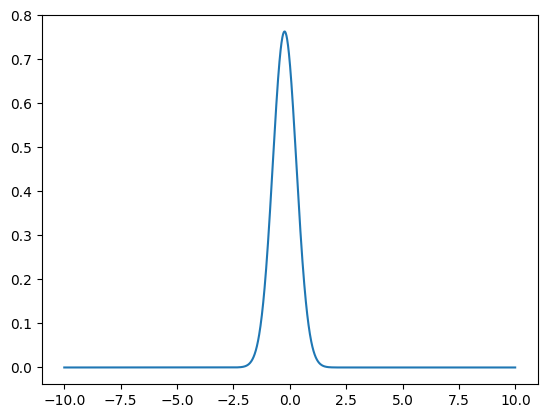

Distribution on encrypted data - Layer 1:


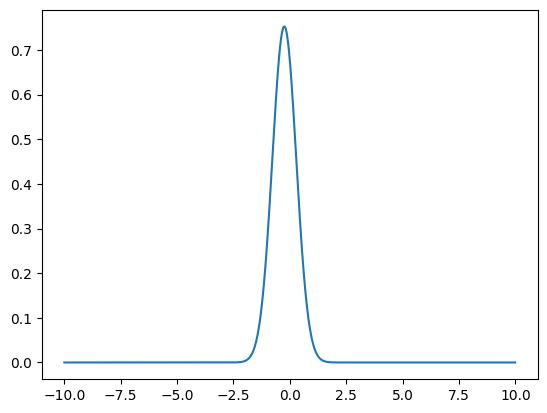

In [31]:
from time import time

# You can use whatever data you want without modification to the tutorial
# x_train, y_train, x_test, y_test = random_data()
x_train, y_train, x_test, y_test = random_data(m=100)

print("############# Data summary #############")
print(f"x_train has shape: {x_train.shape}")
print(f"y_train has shape: {y_train.shape}")
print(f"x_test has shape: {x_test.shape}")
print(f"y_test has shape: {y_test.shape}")
print("#######################################")
# parameters
t_start = time()
enc_x_train = [ts.ckks_vector(context, x.tolist()) for x in x_train]
enc_y_train = [ts.ckks_vector(context, y.tolist()) for y in y_train]
t_end = time()
print(f"Encryption of the training_set took {int(t_end - t_start)} seconds")

normal_dist = lambda x, mean, var: np.exp(- np.square(x - mean) / (2 * var)) / np.sqrt(2 * np.pi * var)


def plot_normal_dist(mean, var, rmin=-10, rmax=10):
    x = np.arange(rmin, rmax, 0.01)
    y = normal_dist(x, mean, var)
    fig = plt.plot(x, y)


# plain distribution
lr = SampleModel()
data = lr.layer1(x_test)
mean, var = map(float, [data.mean(), data.std() ** 2])
plot_normal_dist(mean, var)
print("Distribution on plain data - Layer 1:")
plt.show()


eelr = EncryptedLR(lr)

w_1 = eelr.layer1_weight
b_1 = eelr.layer1_bias
data = []
for enc_x in enc_x_train:
    enc_out = enc_x.mm(w_1) + b_1
    data.append(enc_out.decrypt())
data = torch.tensor(data)
mean, var = map(float, [data.mean(), data.std() ** 2])
plot_normal_dist(mean, var)
print("Distribution on encrypted data - Layer 1:")
plt.show()



In [39]:
def accuracy(model, x, y):
    out = model(x)
    correct = (y>0.5) == (out > 0.5)
    return correct.float().mean()


plain_accuracy = accuracy(sample_model, x_test, y_test)

In [38]:
x_train, y_train, x_test, y_test = random_data(m=100)
enc_x_train = [ts.ckks_tensor(context, x.tolist()) for x in x_train]
enc_y_train = [ts.ckks_tensor(context, y.tolist()) for y in y_train]

eelr = EncryptedLR(sample_model)
accuracy = eelr.plain_accuracy(x_test, y_test)
print(f"Accuracy at epoch #0 is {accuracy}")

times = []
for epoch in range(5):
    eelr.encrypt(context)

    # if you want to keep an eye on the distribution to make sure
    # the function approximation is still working fine
    # WARNING: this operation is time consuming
    # encrypted_out_distribution(eelr, enc_x_train)

    t_start = time()
    for enc_x, enc_y in zip(enc_x_train, enc_y_train):
        enc_out = eelr.forward(enc_x)
        eelr.backward(enc_x, enc_out, enc_y)
    eelr.update_parameters()
    t_end = time()
    times.append(t_end - t_start)

    eelr.decrypt()
    accuracy = eelr.plain_accuracy(x_test, y_test)
    print(f"Accuracy at epoch #{epoch + 1} is {accuracy}")

print(f"\nAverage time per epoch: {int(sum(times) / len(times))} seconds")
print(f"Final accuracy is {accuracy}")

diff_accuracy = plain_accuracy - accuracy
print(f"Difference between plain and encrypted accuracies: {diff_accuracy}")
if diff_accuracy < 0:
    print("Oh! We got a better accuracy when training on encrypted data! The noise was on our side...")

/tmp/ipykernel_189358/2921886035.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w = torch.tensor(self.layer1_weight)
/tmp/ipykernel_189358/2921886035.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b = torch.tensor(self.layer1_bias)
/tmp/ipykernel_189358/2921886035.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w_2 = torch.tensor(self.layer2_weight)
/tmp/ipykernel_189358/2921886035.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().r

Accuracy at epoch #0 is 1.0


KeyboardInterrupt: 

# in-house developed remez for sigmoid

In [ ]:

from numpy.polynomial import Polynomial


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def approximate_sigmoid(x, precision):
    a = -5
    b = 5
    while (b - a) > precision:
        c = (a + b) / 2
        d = (b - a) / 2
        x_points = np.linspace(c - d, c + d, 10)
        y_points = sigmoid(x_points)
        p = Polynomial.fit(x_points, y_points, 6)
        y_c_poly = p(c)
        y_d_poly = p(c + d)
        if y_c_poly < y_d_poly:
            b = c + d
        else:
            a = c
    return p


In [ ]:
import numpy as np
from scipy import optimize


def remez(f, a, b, n):
    # Initialize an arbitrary set of (n+2) points in the interval [a, b]
    x = np.linspace(a, b, n + 2)

    # Set the threshold for convergence
    eps = 1e-6

    while True:
        # Compute the coefficients of the polynomial using the current set of points
        A = np.vander(x - a, n + 1)
        error_coefs = np.array([[(-1) ** i] for i in range(len(x))])
        A = np.append(A, error_coefs, axis=1)

        c = np.linalg.solve(A, f(x))

        E = (error_coefs * c[-1]).flatten()
        c = c[:-1]
        # Compute the error function at the current set of points
        print("Error:")
        print(E)

        x_new = np.array([])
        calculated_pol = np.polynomial.Polynomial(np.flip(c))
        for i in range(n + 1):
            print(f" The x[{i}] is {x[i] - a} and ans for x[{i}]: {f(x[i]) - calculated_pol(x[i] - a)}")

            print(f"The x[{i}+1] is {x[i + 1] - a} and ans for x[{i}+1]: {f(x[i + 1]) - calculated_pol(x[i + 1] - a)}")

            # Compute the point at which the error function attains its maximum or minimum value
            x_star = optimize.bisect(lambda y: (f(y) - calculated_pol(y - a)), x[i], x[i + 1])
            x_new = np.append(x_new, x_star)

        # Check for convergence
        if np.allclose(x, x_new, atol=eps):
            break
        else:
            x = x_new

    # Return the final set of (n+2) points and the coefficients of the polynomial
    return x, c


In [ ]:
remez(sigmoid, -5, 5, 3)